In [3]:
%matplotlib inline
from scipy.spatial import ConvexHull
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import time

# need to install line_profiler: username$ conda install line_profiler
# used to do a line-by-line analysis of the efficiency of the code
%load_ext line_profiler

# load cython to make random number generation faster
%load_ext Cython


# This function sets up more parameters and calls runSimulation
def startSimulation(nlive,D,krep,maxnbact):
    
    # Set up more simulation parameters
    delt = 0.01                                        # time step
    dTime = math.log(2)/krep                           # doubling time
    sigma = dTime/5                                    # width of distribution
    bactpos = np.zeros((int(maxnbact*1.1),2))          # positions of bacteria
    bacthist = np.zeros(int(maxnbact*1.1))             # time experience by bacteria
    bactrep = np.zeros(int(maxnbact*1.1))              # doubling times for bacteria
    rsquared = np.zeros(int(maxnbact*1.1))             # average R^2 for bacteria
    bacteria_number = np.zeros(int(maxnbact*1.1))      # keep track of number of bacteria
        
    # assign doubling times to initial bacteria (normally distributed)
    bactrep[0:nlive] = np.random.normal(dTime, sigma, nlive)

    return runSimulation(0,nlive,2*D*delt,delt,dTime,sigma,bactpos,bacthist,bactrep,bacteria_number,rsquared)


# This function runs the simulation in a for loop until nlive>maxnact
def runSimulation(step,nlive,scaledD,delt,dTime,sigma,bactpos,bacthist,bactrep,bacteria_number,rsquared):
    
    while(1):
        
        # Step 1: end simulation if you have accumulated enough bacteria
        if nlive>maxnbact:
            return bactpos,bacteria_number,nlive,step,rsquared
    
        # Step 2: calculate time
        bacthist[0:nlive] = bacthist[0:nlive] + delt
    
        # Step 3: calculate size of bacterial steps
        delxy = np.multiply(np.array(norm.rvs(size=(nlive,2))), math.sqrt(scaledD))
        bactpos[0:nlive] = bactpos[0:nlive] + delxy
        
        # Step 4: calculate average R^2
        #rsquared[step] = np.mean(np.sum(np.power(bactpos[0:nlive],2),1))
        
        # Step 5: replicate bacteria
        bacthist[0:nlive],newbact,nrep = repBacteria(bactpos[0:nlive],bactrep[0:nlive],bacthist[0:nlive],nlive)
        bactpos[nlive:nlive+nrep] = newbact
        bactrep[nlive:nlive+nrep] = np.random.normal(dTime, sigma, nrep)
        nlive += nrep
        bacteria_number[step] = nlive
        step+=1
            

# This function replicates bacteria when bacthist catches up with bacthist
def repBacteria(bactpos,bactrep,bacthist,nlive):
    repind = bactrep <= bacthist                   #indices of bacteria that will replicate
    nrep = np.sum(repind)                          #number of bacteria that replicate
    newbact = bactpos[repind,:]                    #positions of newly-replicated bacteria
    bacthist[repind] = 0                           #bacterial history is reset to zero
    return bacthist,newbact,nrep

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [4]:
# Smallest enclosing circle - Library (Python)
# 
# Copyright (c) 2017 Project Nayuki
# https://www.nayuki.io/page/smallest-enclosing-circle
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# 
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
# 
# You should have received a copy of the GNU Lesser General Public License
# along with this program (see COPYING.txt and COPYING.LESSER.txt).
# If not, see <http://www.gnu.org/licenses/>.
# 

import math, random


# Data conventions: A point is a pair of floats (x, y). A circle is a triple of floats (center x, center y, radius).

# Returns the smallest circle that encloses all the given points. Runs in expected O(n) time, randomized.
# Input: A sequence of pairs of floats or ints, e.g. [(0,5), (3.1,-2.7)].
# Output: A triple of floats representing a circle.
# Note: If 0 points are given, None is returned. If 1 point is given, a circle of radius 0 is returned.
# 
# Initially: No boundary points known
def make_circle(points):
    # Convert to float and randomize order
    shuffled = [(float(x), float(y)) for (x, y) in points]
    random.shuffle(shuffled)

    # Progressively add points to circle or recompute circle
    c = None
    for (i, p) in enumerate(shuffled):
        if c is None or not is_in_circle(c, p):
            c = _make_circle_one_point(shuffled[ : i + 1], p)
    return c


# One boundary point known
def _make_circle_one_point(points, p):
    c = (p[0], p[1], 0.0)
    for (i, q) in enumerate(points):
        if not is_in_circle(c, q):
            if c[2] == 0.0:
                c = make_diameter(p, q)
            else:
                c = _make_circle_two_points(points[ : i + 1], p, q)
    return c


# Two boundary points known
def _make_circle_two_points(points, p, q):
    circ = make_diameter(p, q)
    left = None
    right = None
    px, py = p
    qx, qy = q

    # For each point not in the two-point circle
    for r in points:
        if is_in_circle(circ, r):
            continue

        # Form a circumcircle and classify it on left or right side
        cross = _cross_product(px, py, qx, qy, r[0], r[1])
        c = make_circumcircle(p, q, r)
        if c is None:
            continue
        elif cross > 0.0 and (left is None or _cross_product(px, py, qx, qy, c[0], c[1]) > _cross_product(px, py, qx, qy, left[0], left[1])):
            left = c
        elif cross < 0.0 and (right is None or _cross_product(px, py, qx, qy, c[0], c[1]) < _cross_product(px, py, qx, qy, right[0], right[1])):
            right = c

    # Select which circle to return
    if left is None and right is None:
        return circ
    elif left is None:
        return right
    elif right is None:
        return left
    else:
        return left if (left[2] <= right[2]) else right


def make_circumcircle(p0, p1, p2):
    # Mathematical algorithm from Wikipedia: Circumscribed circle
    ax, ay = p0
    bx, by = p1
    cx, cy = p2
    ox = (min(ax, bx, cx) + max(ax, bx, cx)) / 2.0
    oy = (min(ay, by, cy) + max(ay, by, cy)) / 2.0
    ax -= ox; ay -= oy
    bx -= ox; by -= oy
    cx -= ox; cy -= oy
    d = (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by)) * 2.0
    if d == 0.0:
        return None
    x = ox + ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    y = oy + ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    ra = math.hypot(x - p0[0], y - p0[1])
    rb = math.hypot(x - p1[0], y - p1[1])
    rc = math.hypot(x - p2[0], y - p2[1])
    return (x, y, max(ra, rb, rc))


def make_diameter(p0, p1):
    cx = (p0[0] + p1[0]) / 2.0
    cy = (p0[1] + p1[1]) / 2.0
    r0 = math.hypot(cx - p0[0], cy - p0[1])
    r1 = math.hypot(cx - p1[0], cy - p1[1])
    return (cx, cy, max(r0, r1))


_MULTIPLICATIVE_EPSILON = 1 + 1e-14

def is_in_circle(c, p):
    return c is not None and math.hypot(p[0] - c[0], p[1] - c[1]) <= c[2] * _MULTIPLICATIVE_EPSILON


# Returns twice the signed area of the triangle defined by (x0, y0), (x1, y1), (x2, y2).
def _cross_product(x0, y0, x1, y1, x2, y2):
    return (x1 - x0) * (y2 - y0) - (y1 - y0) * (x2 - x0)


In [5]:
%%cython

# This code makes Gaussian random number generation faster than numpy

from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport log, sqrt
import numpy as np
import cython

cdef double random_uniform():
    cdef double r = rand()
    return r / RAND_MAX

cdef double random_gaussian():
    cdef double x1, x2, w

    w = 2.0
    while (w >= 1.0):
        x1 = 2.0 * random_uniform() - 1.0
        x2 = 2.0 * random_uniform() - 1.0
        w = x1 * x1 + x2 * x2

    w = ((-2.0 * log(w)) / w) ** 0.5
    return x1 * w


@cython.boundscheck(False)
cdef void assign_random_gaussian_pair(double[:] out, int assign_ix):
    cdef double x1, x2, w

    w = 2.0
    while (w >= 1.0):
        x1 = 2.0 * random_uniform() - 1.0
        x2 = 2.0 * random_uniform() - 1.0
        w = x1 * x1 + x2 * x2

    w = sqrt((-2.0 * log(w)) / w)
    out[assign_ix] = x1 * w
    out[assign_ix + 1] = x2 * 2


@cython.boundscheck(False)
def my_gaussian_fast(int n):
    cdef int i
    cdef double[:] result = np.zeros(n, dtype='f8', order='C')
    for i in range(n // 2):  # Int division ensures trailing index if n is odd.
        assign_random_gaussian_pair(result, i * 2)
    if n % 2 == 1:
        result[n - 1] = random_gaussian()

    return result

In [4]:
# Use this block of code to run simulation N number of times
# Set N=1 if you want to run simulation once

# Simulation parameters
D = 1.0                                           # diffusion coefficient
krep = 1.0                                        # replication rate
nlive = 25                                        # initial number of bacteria
maxnbact = int(1e5)                               # max number of bacteria

N = 1                                             # number of times to run sim
circData = np.zeros((N,1))                        # circularity data
bactNumData = np.zeros((int(maxnbact*1.1),N))     # bactnum data
rsquaredData = np.zeros((int(maxnbact*1.1),N))    # R^2 data
bactposData = np.zeros((int(maxnbact*1.1),2,N))   # bactpos data


# Run simulation N number of times
t0 = time.time()
for each in range(0,N):
    bactpos,bacteriaNum,maxlive,step,rsquared = startSimulation(nlive,D,krep,maxnbact)
    hull = ConvexHull(bactpos)
    x,y,r = make_circle(bactpos[hull.vertices])
    circData[each] = 1 - hull.area/(3.14*(r**2))
    bactposData[:,:,each] = bactpos
    bactNumData[:,each] = bacteriaNum
    rsquaredData[:,each] = rsquared
print(time.time()-t0, "seconds process time")

# Print mean of circularity data
print("Mean Circularity =",round(np.mean(circData),2))

0.8280918598175049 seconds process time
Mean Circularity = 0.9


109.10707962788089
1097.4621514133653
0.9005823759048388


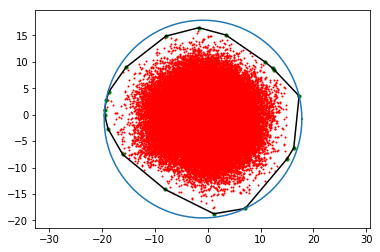

In [5]:
# Use this code to visualize specific simulation runs

# First, decide which simulation run you want to look at in range(0,N), and extract those data
simRun = 0
bactNum = bactNumData[:,simRun]
bactpos = bactposData[:,:,simRun]
rsquared = rsquaredData[:,simRun]


# Second, calculate convex hull of bacterial focus and plot it
plt.scatter(bactpos[0:maxlive][:,0], bactpos[0:maxlive][:,1],1,'r')
hull = ConvexHull(bactpos)
for simplex in hull.simplices:
    plt.plot(bactpos[simplex, 0], bactpos[simplex, 1], 'k-')
plt.axis('equal')
plt.show


# Third, determine area of smallest enclosing circle (and plot it)
plt.scatter(bactpos[hull.vertices][:,0],bactpos[hull.vertices][:,1],10,'g')
x,y,r = make_circle(bactpos[hull.vertices])
areaCircle = np.pi*(r**2)
an = np.linspace(0, 2*np.pi, 100)
plt.plot(r*np.cos(an)+x, r*np.sin(an)+y)


# Finally, calculate ratio of areas
circularity = 1 - hull.area/areaCircle
print(hull.area)
print(areaCircle)
print(circularity)

In [ ]:
# Plot exponential bacterial growth
delt = 0.01
maxTime = step*delt
time = np.arange(0, maxTime, delt)
plt.plot(time[0:step],bactNum[0:step])
plt.xlabel('Time')
plt.ylabel('Number of Bacteria')
plt.title('Exponential Bacterial Growth')
plt.show

def expfunc(x, a, b):
    return a * np.exp(b * x)

expOpt, expCov = curve_fit(expfunc, time[0:step], bactNum[0:step])
print('Replication rate = %s' % expOpt[1])

In [ ]:
# Plot average r^2
plt.plot(time[0:step],rsquared[0:step])
plt.xlabel('Time')
plt.ylabel('Average R Squared')
plt.title('Linearity of Second Moment')
plt.show

def linfunc(x, m, b):
    return m*x+b

linOpt, expCov = curve_fit(linfunc, time[0:step], rsquared[0:step])
DiffCoeff = linOpt[0]/4
print('Diffusion Coefficient = %s' % DiffCoeff)

In [ ]:
# Use this to profile the simulation line by line

%lprun -f runSimulation startSimulation(nlive,D,krep,maxnbact)

In [12]:
# Fun speed test

from scipy.stats import norm
import time
numTrials = 1
SciPyTimes = np.zeros((numTrials,1))
CythonTimes = np.zeros((numTrials,1))
testNumber = 10000000

for ii in range(0,numTrials):
    # Test scipy generation of random numbers drawn from Gaussian
    
    startTime = time.time()
    r = norm.rvs(size=testNumber)
    endTime = time.time()
    myTime = endTime - startTime
    SciPyTimes[ii] = myTime
    #print('SciPy took %s seconds to calculate.' % myTime)

    # Test Cython generation of random numbers drawn from Gaussian
    startTime2 = time.time()
    r2 = my_gaussian_fast(testNumber)
    endTime2 = time.time()
    myTime2 = endTime2 - startTime2
    CythonTimes[ii] = myTime2
    #print('Cython took %s seconds to calculate.' % myTime2)

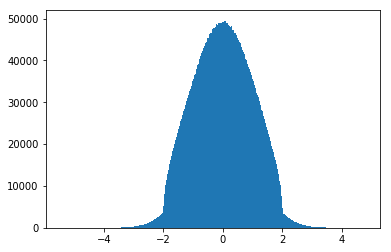

In [13]:
plt.hist(r2, bins='auto')  # arguments are passed to np.histogram
plt.show()
#print('Cython was %s times faster than SciPy.' % (round(myTime/myTime2,2)))

In [ ]:
import 